In [144]:
%matplotlib inline

import sys

sys.path.append("..")

In [124]:
import os
import pickle
import shutil
import torch

from torch.nn import PairwiseDistance, CosineSimilarity
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm_notebook as tqdm

from src.datasets import get_dataset, get_dataset_class_names
from src.models.hog import HOGLayer
from src.utils import get_device
from src.visualization import plot_image_batch, plot_image

In [125]:
dataset_name = 'sketchy_sketches'
embedding_directory_name = 'hog_sketches_gist'
query_image_filename = r'C:\Users\Chopan\Documents\Data\sketchy\sketch\tx_000000000000\swan\n01858441_2970-2.png'
in_channels = 3
cell_size = 24
n_bins = 9
signed_gradients = False
batch_size = 32
workers = 6
n_gpu = 0
k = 16
distance = 'cosine'

In [121]:
device = get_device(n_gpu)
dataset = get_dataset(dataset_name, transforms.Grayscale(num_output_channels=1))
model = HOGLayer()
model = model.to(device)

---

In [49]:
outputs = []

for i, data in tqdm(enumerate(dataset), total=len(dataset)):
    image, label = data
    image = image.to(device)
    output = model(image.unsqueeze(0))
    outputs.append(output)
    
embeddings = torch.cat(outputs)

In [52]:
import pickle

pickle.dump(outputs, open(r'outputs.pickle', 'wb'))

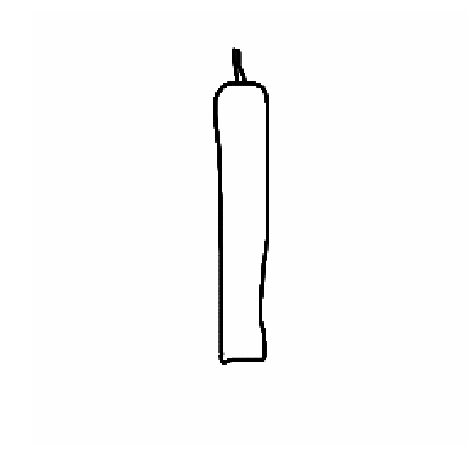

In [122]:
image, image_class = dataset[12435]
image = image.to(device)
plot_image_batch([image, image_class])

query image class = airplane
distances = tensor([1.0000, 0.9082, 0.9082, 0.9078, 0.9077, 0.9077, 0.9076, 0.9075, 0.9075,
        0.9072, 0.9072, 0.9072, 0.9072, 0.9072, 0.9071, 0.9071])
classes = ['airplane', 'ant', 'ant', 'crab', 'ant', 'ant', 'bee', 'helicopter', 'bee', 'rocket', 'cat', 'sword', 'frog', 'bee', 'racket', 'scorpion']
indexes = tensor([    0,  1824,  1668, 18663,  1702,  1776,  6654, 32164,  6466, 52433,
        14656, 65304, 26501,  6468, 50153, 55206])


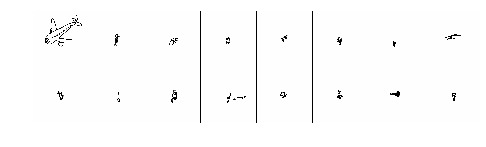

In [92]:
query_embedding = model(image.unsqueeze(0))
p_dist = PairwiseDistance(p=2) if distance == 'pairwise' else CosineSimilarity()
distances = p_dist(embeddings, query_embedding)
# Return the top k results
top_distances, top_indices = torch.topk(distances, k)
aux = [dataset[j] for j in top_indices]
image_tensors = torch.stack([tup[0] for tup in aux])
image_classes = [tup[1] for tup in aux]
image_class_names = get_dataset_class_names(dataset_name)
print('query image class = {}'.format(image_class_names[image_class]))
print('distances = {}'.format(top_distances))
print('classes = {}'.format([image_class_names[class_name] for class_name in image_classes]))
print('indexes = {}'.format(top_indices))
plot_image_batch([image_tensors, image_classes])

query image class = airplane
distances = tensor([1.0000, 0.9082, 0.9082, 0.9078, 0.9077, 0.9077, 0.9076, 0.9075, 0.9075,
        0.9072, 0.9072, 0.9072, 0.9072, 0.9072, 0.9071, 0.9071])
classes = ['airplane', 'ant', 'ant', 'crab', 'ant', 'ant', 'bee', 'helicopter', 'bee', 'rocket', 'cat', 'sword', 'frog', 'bee', 'racket', 'scorpion']
indexes = tensor([    0,  1824,  1668, 18663,  1702,  1776,  6654, 32164,  6466, 52433,
        14656, 65304, 26501,  6468, 50153, 55206])


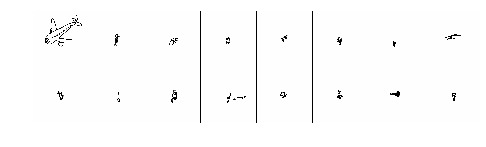

In [93]:
query_embedding = embeddings[0].unsqueeze(0)
p_dist = PairwiseDistance(p=2) if distance == 'pairwise' else CosineSimilarity()
distances = p_dist(embeddings, query_embedding)
# Return the top k results
top_distances, top_indices = torch.topk(distances, k)
aux = [dataset[j] for j in top_indices]
image_tensors = torch.stack([tup[0] for tup in aux])
image_classes = [tup[1] for tup in aux]
image_class_names = get_dataset_class_names(dataset_name)
print('query image class = {}'.format(image_class_names[image_class]))
print('distances = {}'.format(top_distances))
print('classes = {}'.format([image_class_names[class_name] for class_name in image_classes]))
print('indexes = {}'.format(top_indices))
plot_image_batch([image_tensors, image_classes])

In [94]:
model(image.unsqueeze(0))

tensor([[0.8750, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [95]:
model(image.unsqueeze(0)).shape

torch.Size([1, 10240])

In [96]:
embeddings[0].unsqueeze(0)

tensor([[0.8750, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [97]:
embeddings[0].unsqueeze(0).shape

torch.Size([1, 10240])

In [98]:
model(image.unsqueeze(0)) == embeddings[0].unsqueeze(0)

tensor([[1, 1, 1,  ..., 1, 1, 1]], dtype=torch.uint8)

In [99]:
(model(image.unsqueeze(0)) == embeddings[0].unsqueeze(0)).any()

tensor(1, dtype=torch.uint8)

In [100]:
(model(image.unsqueeze(0)) == embeddings[0].unsqueeze(0)).sum()

tensor(10240)

---

So now that I'm sure that it works iterating over the dataset, I will try with the dataloader.

In [106]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

output_batches = []

for i, data in tqdm(enumerate(data_loader, 0), total=len(data_loader)):  # iterate batches
    inputs, labels = data
    outputs = model(inputs.to(device))
    output_batches.append(outputs)

In [107]:
import pickle

pickle.dump(outputs, open(r'outputs_batches.pickle', 'wb'))

In [109]:
embeddings = torch.cat(output_batches)

In [110]:
embeddings.shape

torch.Size([75481, 10240])

query image class = candle
distances = tensor([1.0000, 0.9781, 0.9769, 0.9753, 0.9753, 0.9750, 0.9748, 0.9748, 0.9747,
        0.9747, 0.9746, 0.9743, 0.9743, 0.9743, 0.9741, 0.9739])
classes = ['candle', 'candle', 'candle', 'candle', 'sword', 'candle', 'blimp', 'chair', 'candle', 'rocket', 'candle', 'spoon', 'candle', 'candle', 'dog', 'blimp']
indexes = tensor([12435, 12570, 12537, 12422, 65171, 12569,  9257, 15621, 12423, 52424,
        12419, 62558, 12540, 12432, 21110,  9461])


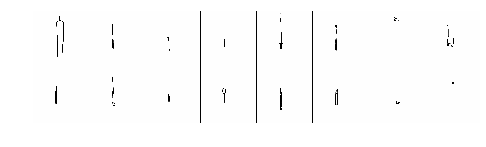

In [118]:
query_embedding = model(image.unsqueeze(0))
p_dist = PairwiseDistance(p=2) if distance == 'pairwise' else CosineSimilarity()
distances = p_dist(embeddings, query_embedding)
# Return the top k results
top_distances, top_indices = torch.topk(distances, k)
aux = [dataset[j] for j in top_indices]
image_tensors = torch.stack([tup[0] for tup in aux])
image_classes = [tup[1] for tup in aux]
image_class_names = get_dataset_class_names(dataset_name)
print('query image class = {}'.format(image_class_names[image_class]))
print('distances = {}'.format(top_distances))
print('classes = {}'.format([image_class_names[class_name] for class_name in image_classes]))
print('indexes = {}'.format(top_indices))
plot_image_batch([image_tensors, image_classes])

---

In [131]:
from src.models.hog import HOG
n_gpu = 1
device = get_device(n_gpu)
dataset = get_dataset(dataset_name)
model = HOG(in_channels, cell_size, n_bins, signed_gradients)
model = model.to(device)

In [132]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

output_batches = []

for i, data in tqdm(enumerate(data_loader, 0), total=len(data_loader)):  # iterate batches
    inputs, labels = data
    outputs = model(inputs.to(device))
    pickle.dump(outputs.to('cpu'), open(os.path.join('asd', 'batch_{}.pickle'.format(i)), 'wb'))

In [133]:
embedding_directory = 'asd'

embeddings = torch.cat([
    pickle.load(open(os.path.join(embedding_directory, f), 'rb')).to(device)
    for f in tqdm(os.listdir(embedding_directory), desc='Loading {} embeddings'.format(embedding_directory_name))
    if 'tsne' not in f # skip possible projection pickle in the embedding directory
])

In [136]:
embeddings.shape

torch.Size([75481, 900])

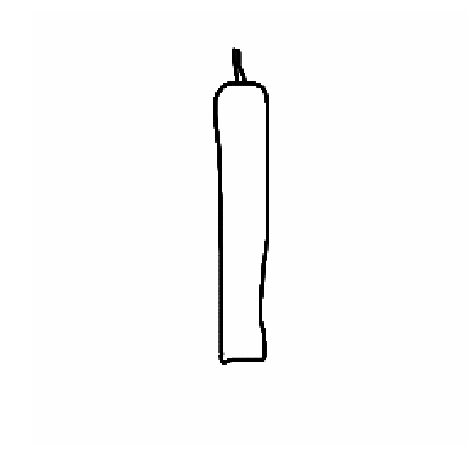

In [137]:
image, image_class = dataset[12435]
image = image.to(device)
plot_image_batch([image, image_class])

query image class = candle
distances = tensor([1.0000, 0.9292, 0.9250, 0.9032, 0.9005, 0.8990, 0.8899, 0.8884, 0.8880,
        0.8864, 0.8847, 0.8835, 0.8798, 0.8794, 0.8778, 0.8767],
       device='cuda:0')
classes = ['saxophone', 'saxophone', 'door', 'bee', 'pizza', 'kangaroo', 'owl', 'door', 'duck', 'saxophone', 'wheelchair', 'bee', 'kangaroo', 'saxophone', 'fan', 'apple']
indexes = tensor([53772, 54028, 22274,  6280, 47142, 37054, 41562, 22645, 22912, 54053,
        72583,  6340, 37127, 54054, 25204,  2600], device='cuda:0')


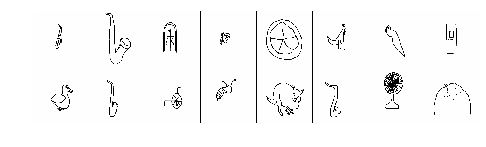

In [138]:
query_embedding = model(image.unsqueeze(0))
p_dist = PairwiseDistance(p=2) if distance == 'pairwise' else CosineSimilarity()
distances = p_dist(embeddings, query_embedding)
# Return the top k results
top_distances, top_indices = torch.topk(distances, k)
aux = [dataset[j] for j in top_indices]
image_tensors = torch.stack([tup[0] for tup in aux])
image_classes = [tup[1] for tup in aux]
image_class_names = get_dataset_class_names(dataset_name)
print('query image class = {}'.format(image_class_names[image_class]))
print('distances = {}'.format(top_distances))
print('classes = {}'.format([image_class_names[class_name] for class_name in image_classes]))
print('indexes = {}'.format(top_indices))
plot_image_batch([image_tensors, image_classes])

---

In [141]:
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=workers)

output_batches = []

for i, data in tqdm(enumerate(data_loader, 0), total=len(data_loader)):  # iterate batches
    inputs, labels = data
    outputs = model(inputs.to(device))
    output_batches.append(outputs.to('cpu'))

In [142]:
embeddings = torch.cat(output_batches)
embeddings.shape

torch.Size([75481, 900])

query image class = candle
distances = tensor([1.0000, 0.9292, 0.9250, 0.9032, 0.9005, 0.8990, 0.8899, 0.8884, 0.8880,
        0.8864, 0.8847, 0.8835, 0.8798, 0.8794, 0.8778, 0.8767])
classes = ['candle', 'candle', 'rocket', 'knife', 'wine_bottle', 'sword', 'trumpet', 'rocket', 'rocket', 'candle', 'hammer', 'knife', 'sword', 'candle', 'scissors', 'hotdog']
indexes = tensor([12435, 12659, 51970, 37576, 74342, 65278, 69338, 52309, 52544, 12684,
        29358, 37636, 65319, 12685, 54612, 34248])


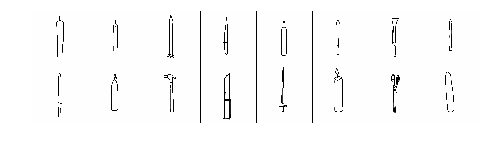

In [146]:
query_embedding = model(image.unsqueeze(0)).to('cpu')
p_dist = PairwiseDistance(p=2) if distance == 'pairwise' else CosineSimilarity()
distances = p_dist(embeddings, query_embedding)
# Return the top k results
top_distances, top_indices = torch.topk(distances, k)
aux = [dataset[j] for j in top_indices]
image_tensors = torch.stack([tup[0] for tup in aux])
image_classes = [tup[1] for tup in aux]
image_class_names = get_dataset_class_names(dataset_name)
print('query image class = {}'.format(image_class_names[image_class]))
print('distances = {}'.format(top_distances))
print('classes = {}'.format([image_class_names[class_name] for class_name in image_classes]))
print('indexes = {}'.format(top_indices))
plot_image_batch([image_tensors, image_classes])

Mi HOG funciona mejor.